In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.insert(1, "..")

import utils as u
import eda as e
import stats as s

pd.set_option("mode.chained_assignment", None)

# Project HER2

## Created by Stilyan Chanev

## Project Idea: Integrate breast cancer molecular subtype data with drug response profiles

### Hypothesis: HER2-positive tumors have higher HER2 pathway activity, and HER2-targeted (or closely related) drugs reduce cancer cell viability more than non-targeted agents.

### Objective: Compare HER2 pathway activation between HER2-positive and -negative tumors and evaluate whether that activation aligns with stronger drug efficacy in corresponding targeted treatments.

## Abstract

<p style="font-size:18px;"> HER2-positive breast cancer is driven by ERBB2 signaling and is clinically actionable; we analyze two curated datasets to test whether (i) higher HER2 pathway activity relates to survival, (ii) HER2-targeted drugs reduce in-vitro viability more than non-targeted agents, and (iii) clinical HER2 status aligns with pathway activation. Using a median split of pp_HER2, vital status differed between High and Low groups ($\chi$^2 p=0.040; Fisher p=0.031), with lower death odds in the High group (OR=0.55; deaths 9.1% vs 15.4%). Pooled across doses, HER2-targeted inhibitors exhibit markedly lower viability distributions than comparators, consistent with greater potency. Finally, HER2-positive tumors show higher pathway activity than HER2-negative tumors, with median pp_HER2 1.881 vs −0.154. Together, these nonparametric results - robust to skew and ties - support biological coherence across label, signaling, and function: HER2 positivity tracks elevated phospho-HER2 signaling, and HER2-directed agents more strongly suppress cell viability, mirroring clinical experience with HER2-targeted therapy. </p>

## 1. Introduction, Ideas and Background of the Project

### 1.1. Main Ideas and Aims

<p style="font-size:18px;"> ProjectHER2 is a natural evolution of my earlier work in ProjectDNA, where I explored mutation models (Jukes-Cantor and Markov chains) to understand how biological sequences change and propagate information. In that project the focus was on modeling and quantifying uncertainty in genetic data; here, I take the next step downstream and ask how molecular identity - specifically a clinically used label, HER2-positive breast cancer - is reflected in real biological signal and whether that signal predicts functional response to therapy. In other words, if the genome and proteome encode a subtype, does the treatment landscape behave as theory and biology would suggest? </p>

<p style="font-size:18px;"> The core idea is to connect two independent data worlds: patient-derived molecular profiles (showing pathway activation and subtype labels) and in vitro drug sensitivity measurements. I test whether the HER2-positive phenotype corresponds to elevated HER2 pathway activity and whether drugs targeting that axis (or close biological proxies) result in stronger reductions in cancer cell viability. This project is about alignment - between label, underlying biology, and therapeutic effect - and demonstrates the data science pipeline from molecular signal to actionable insight, explaining the precision-medicine philosophy: use what the tumor "says" to choose what should be done. Cells won't stop fascinating me! ;) </p>

![Human cell](../images/HumanCell.jpg)

### 1.2. Biological Background

<p style="font-size:18px;"> This project builds upon the biological foundations established in ProjectDNA, where core concepts such as cells, DNA, genes, the genome, and the nature of mutations were introduced in detail. For the purposes of ProjectHER2, we focus on how these molecular principles connect to breast cancer biology and targeted therapy. </p>

#### 1.2.1. HER2

<p style="font-size:18px;"> HER2 (human epidermal growth factor receptor 2) is a protein that plays a key role in regulating cell growth and division. In some breast cancers, the HER2 gene is amplified or overexpressed, leading to abnormally high levels of HER2 protein on the tumor cell surface. This "HER2-positive" status drives more aggressive tumor growth but also creates a therapeutic opportunity - drugs targeting the HER2 pathway can inhibit this signaling and reduce tumor viability. The biological insight that HER2 can drive cancer led directly to targeted therapies and dramatically better outcomes for HER2-positive patients. Clinically, this went from concept to survival gains in randomized trials. Adding tucatinib (a selective HER2 TKI) to trastuzumab/capecitabine improved progression-free and overall survival in HER2CLIMB; lapatinib plus capecitabine improved outcomes versus capecitabine alone in trastuzumab-pretreated disease - clear proof that shutting down HER2 signaling helps patients. </p>

![HER2](../images/HER2.jpg)

#### 1.2.2. ER and PR

<p style="font-size:18px;"> Two additional hormone receptors - estrogen receptor (ER - proteins found in cells that act as receptors for the hormone estrogen) and progesterone receptor (PR - proteins that bind to the hormone progesterone, triggering changes within cells) - are often assessed in breast cancer. Together, HER2, ER, and PR status define key molecular subtypes that influence prognosis and treatment choices. </p>

![ER](../images/ER.jpg)

![PR](../images/PR.jpg)

#### 1.2.3. pp_HER2

<p style="font-size:18px;"> HER2 pathway activity can be measured at the protein level, including its phosphorylated form (pp_HER2), which reflects receptor activation. In ProjectHER2, pp_HER2 serves as the primary molecular readout for pathway activation, and its relationship to HER2 status, survival outcomes, and drug response is central to our analysis. </p>

![Phosphorylation](../images/Phosphorylation.jpg)

#### 1.2.4. Breast Cancer

<p style="font-size:18px;"> Breast cancer begins when epithelial cells in the breast acquire alterations that allow uncontrolled growth and invasion. In practice, tumors are stratified by receptor biology - estrogen receptor (ER), progesterone receptor (PR), and HER2 - because these markers drive behavior and guide therapy. Patient-facing and clinical sources summarize the spectrum of symptoms, risk factors, staging, and multimodality care across surgery, radiation, endocrine therapy, chemotherapy, and targeted agents, framing why subtype matters for prognosis and treatment choice. </p>

![Breast Cancer](../images/BreastCancer.jpg)

#### 1.2.5. HER2 Pathway Activity

<p style="font-size:18px;"> Signal transduction through HER2 is phosphorylation-driven. A well-studied activation site is Tyr1248 (Y1248) on the HER2 cytoplasmic tail; phosphorylation at Y1248 (pY1248) tracks receptor activation and propagates downstream signals. Prior proteomic studies show elevated pHER2(Y1248) in HER2-driven contexts and link phospho-HER2 measurements to disease biology and outcome, reinforcing the idea that phospho-status captures activity, not just expression. In our data, pp_HER2 (and when present a pY1248-specific readout) serve as pathway-activity proxies. </p>

![HER2 Pathway Activity](../images/Pathway.jpg)

#### 1.2.6. Viability

<p style="font-size:18px;"> To quantify drug effects in cell culture, high-throughput viability assays measure metabolically active/ATP-rich cells after treatment. A widely used method, CellTiter-Glo, reads cellular ATP via a luciferase reaction - more luminescence means more viable cells. Readouts are normalized to untreated controls to produce a fraction (0-1 or 0-100%) of surviving cells. Lower viability implies stronger growth inhibition, enabling dose–response curves and potency metrics like $IC_{50}$ (the concentration that reduces response to 50%). We leverage both pooled viability distributions and a simple "fraction < 50% viability" descriptor to summarize potency across doses, aligning with pharmacology guidance for concentration-response analysis. </p>

## 2. Data Description

### 2.1. Datasets Overview

<p style="font-size:18px;"> This project uses two independent CSV datasets that are connected via biological meaning. **Mutations / Proteomic Profile Data (`mutations.csv`)** shows patient-derived breast cancer samples with clinical subtype labels (like HER2 status, ER/PR status, histological type, survival) and quantitative pathway activity measurements. This dataset comes from The Cancer Genome Atlas (TCGA) breast cancer (BRCA) cohort, repackaged on Kaggle. Key features for this project are `HER2.Final.Status` and HER2 pathway activation proxies like `pp_HER2` and `pp_HER2.pY1248`. **Drug Sensitivity Data (`drug-sensitivity.csv`)** displays in vitro viability measurements of cancer cell lines after treatment with various drugs. This dataset comes from the Genomics of Drug Sensitivity in Cancer (GDSC) project, specifically the Sanger GDSC1 & GDSC2 screens, accessed via DepMap. Important columns are `DRUG_NAME`, `dose`, and `viability` (survival fraction), which allow comparison of targeted versus non-targeted drug effects. </p>

### 2.2. Loading and Initial Inspection

<p style="font-size:18px;"> Now I present the data loading step in code.<br>
The function <code>load_data()</code> takes: </p>
<ul>
  <li><b>data_dir</b> – path to the folder containing <code>mutations.csv</code> and <code>drug-sensitivity.csv</code>.</li>
</ul>

In [2]:
mutations_data, drug_sensitivity_data = u.load_data("../data")

<p style="font-size:18px;"> Let's begin with the size of the data we have here. </p>

In [3]:
print("Mutations data shape:", mutations_data.shape)
print("Drug sensitivity data shape:", drug_sensitivity_data.shape)

Mutations data shape: (705, 1941)
Drug sensitivity data shape: (4049857, 8)


In [4]:
display(mutations_data.head(5))
display(drug_sensitivity_data.head(5))

,rs_CLEC3A,rs_CPB1,rs_SCGB2A2,rs_SCGB1D2,rs_TFF1,rs_MUCL1,rs_GSTM1,rs_PIP,rs_ADIPOQ,rs_ADH1B,...,pp_p62.LCK.ligand,pp_p70S6K,pp_p70S6K.pT389,pp_p90RSK,pp_p90RSK.pT359.S363,vital.status,PR.Status,ER.Status,HER2.Final.Status,histological.type
0,0.892818,6.580103,14.123672,10.606501,13.189237,6.649466,10.520335,10.338490,10.248379,10.229970,...,-0.691766,-0.337863,-0.178503,0.011638,-0.207257,0,Positive,Positive,Negative,infiltrating ductal carcinoma
1,0.000000,3.691311,17.116090,15.517231,9.867616,9.691667,8.179522,7.911723,1.289598,1.818891,...,0.279067,0.292925,-0.155242,-0.089365,0.267530,0,Positive,Negative,Negative,infiltrating ductal carcinoma
2,3.748150,4.375255,9.658123,5.326983,12.109539,11.644307,10.517330,5.114925,11.975349,11.911437,...,0.219910,0.308110,-0.190794,-0.222150,-0.198518,0,Positive,Positive,Negative,infiltrating ductal carcinoma
3,0.000000,18.235519,18.535480,14.533584,14.078992,8.913760,10.557465,13.304434,8.205059,9.211476,...,-0.266554,-0.079871,-0.463237,0.522998,-0.046902,0,Positive,Positive,Negative,infiltrating ductal carcinoma
4,0.000000,4.583724,15.711865,12.804521,8.881669,8.430028,12.964607,6.806517,4.294341,5.385714,...,-0.441542,-0.152317,0.511386,-0.096482,0.037473,0,Positive,Positive,Negative,infiltrating ductal carcinoma


,DRUG_ID,COSMIC_ID,dose,viability,DATASET,ARXSPAN_ID,DRUG_NAME,BROAD_ID
0,1007,924238,0.012500,0.183654,GDSC1,ACH-002148,DOCETAXEL,"BRD-K30577245, BRD-A05821830, BRD-K63265447, B..."
1,1007,924238,0.006250,0.104707,GDSC1,ACH-002148,DOCETAXEL,"BRD-K30577245, BRD-A05821830, BRD-K63265447, B..."
2,1007,924238,0.003125,0.282676,GDSC1,ACH-002148,DOCETAXEL,"BRD-K30577245, BRD-A05821830, BRD-K63265447, B..."
3,1007,924238,0.001563,0.325207,GDSC1,ACH-002148,DOCETAXEL,"BRD-K30577245, BRD-A05821830, BRD-K63265447, B..."
4,1007,924238,0.000781,0.526366,GDSC1,ACH-002148,DOCETAXEL,"BRD-K30577245, BRD-A05821830, BRD-K63265447, B..."


In [5]:
mutations_data.info(verbose=False, show_counts=True)
mutations_data.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 1941 entries, rs_CLEC3A to histological.type
dtypes: float64(827), int64(1110), object(4)
memory usage: 10.4+ MB


int64      1110
float64     827
object        4
Name: count, dtype: int64

In [6]:
cols = mutations_data.columns
out = []

for c in cols:
    ser = mutations_data[c]
    non_null = ser.notna().sum()
    null_pct = 100.0 * (1.0 - non_null / max(len(mutations_data), 1))
    try:
        ex = ser.dropna().iloc[0]
    except Exception:
        ex = None
        
    out.append({
        "name": c,
        "dtype": str(ser.dtype),
        "non_null": int(non_null),
        "null_pct": round(null_pct, 2),
        "n_unique": int(ser.nunique(dropna=True)),
        "example": ex
    })
    
table = pd.DataFrame(out).T
table

,0,1,2,3,4,5,6,7,8,9,...,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940
name,rs_CLEC3A,rs_CPB1,rs_SCGB2A2,rs_SCGB1D2,rs_TFF1,rs_MUCL1,rs_GSTM1,rs_PIP,rs_ADIPOQ,rs_ADH1B,...,pp_p62.LCK.ligand,pp_p70S6K,pp_p70S6K.pT389,pp_p90RSK,pp_p90RSK.pT359.S363,vital.status,PR.Status,ER.Status,HER2.Final.Status,histological.type
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,int64,object,object,object,object
non_null,705,705,705,705,705,705,705,705,705,705,...,705,705,705,705,705,705,583,583,560,705
null_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17.3,17.3,20.57,0.0
n_unique,522,672,691,680,666,683,667,684,678,670,...,705,704,701,705,705,2,5,5,4,2
example,0.892818,6.580103,14.123672,10.606501,13.189237,6.649466,10.520335,10.33849,10.248379,10.22997,...,-0.691766,-0.337863,-0.178503,0.011638,-0.207257,0,Positive,Positive,Negative,infiltrating ductal carcinoma


<p style="font-size:18px;"> The `mutations_data` table contains breast cancer patient samples with rich molecular and clinical annotations. Its shape reflects the number of tumor samples (rows) and the many features measured per sample (columns), including clinical subtype labels such as HER2, ER, and PR status, survival indicator, histological type, and quantitative pathway activity markers like `pp_HER2` and `pp_HER2.pY1248`. The first few rows demonstrate the format: each sample carries both its subtype label and the corresponding level of HER2 pathway activation, which will serve as the biological signal in the downstream analysis. </p>

<p style="font-size:18px;"> The `drug_sensitivity_data` table captures in vitro drug response experiments. Each row is a single drug-cell line-dose measurement, with the drug identity (`DRUG_NAME`), the applied concentration (`dose`), and the resulting cell viability (`viability`). The preview shows raw survival fractions across different drugs and doses, which will be used to assess and compare the effectiveness of HER2-related (or proxy) targeted agents versus non-targeted comparators. </p>

### 2.3. Immediate Observations and Next Steps

<p style="font-size:18px;"> From here, the next steps are to quantify the balance and quality of these data: count how many samples are labeled HER2-positive versus HER2-negative in `mutations_data`, and summarize the distribution of HER2 pathway activity within each group. In the drug data, identify the set of targeted versus comparator drugs, and compute basic summary statistics (like median viability) for each. This will establish the two analytical strands - tumor biology and drug response - that will later be integrated to test the central hypothesis. </p>

## 3. Data Preprocessing

<p style="font-size:18px;"> This section prepares both datasets for analysis: tumor biology (HER2 status and pathway activity) and drug response. The goal is to enforce consistency, create clean group definitions, normalize quantitative signals, and define the targeted vs comparator drug sets. Precise notation is introduced to make downstream hypotheses and tests unambiguous. </p>

### 3.1. Notation and Variables

<p style="font-size:18px;"> Let $i$ index patient tumor samples.  </p>

<p style="font-size:18px;"> Let $H_i \in \{0,1\} $ be the binary HER2 status indicator:
  $$
  H_i = 
  \begin{cases}
    1 & \text{if sample } i \text{ is HER2-positive} \\
    0 & \text{if sample } i \text{ is HER2-negative}
  \end{cases}
  $$ </p>
  
<p style="font-size:18px;"> Let $x_i$ denote the raw HER2 pathway activity measurement for sample $i$ (like `pp_HER2` or `pp_HER2.pY1248`). </p>
                                                                                        
<p style="font-size:18px;"> Let $j$ index drug treatment experiments. For drug $j$, let $D_j$ be its name, $d_j$ the dose, and $ v_j$ the observed viability. </p>

<p style="font-size:18px;"> We will define two drug categories. First one is: Targeted drugs $\mathcal{T}$: agents acting on the HER2/HER-family axis or closest biological proxies (Lapatinib, Neratinib, EGFR inhibitors if exact HER2 inhibitors are absent). Next come Comparator drugs $\mathcal{C}$: non-targeted standard treatments (Docetaxel) used as a baseline. </p>

### 3.2. Cleaning and Filtering

#### 3.2.1. Mutations Data

<p style="font-size:18px;"> Before any numeric transformation, we inspect and choose which columns will be used for the core analysis and which will be set aside (or used later as extensions). The dataset is wide; most features are not needed for the primary hypothesis, so we reduce complexity by keeping only what directly supports the test of HER2 signaling vs drug sensitivity. </p>

| Column / Prefix | Meaning (intuition) | Use in core analysis |
|-----------------|---------------------|----------------------|
| `HER2.Final.Status`, `ER.Status`, `PR.Status` | Clinical subtype labels (hormone receptor status) | **Keep** (grouping, context) |
| `vital.status` | Outcome / survival indicator | Optional (exploratory) |
| `histological.type` | Tumor histology | Optional (context / stratification) |
| `pp_HER2`, `pp_HER2.pY1248` | HER2 protein level and activation (phosphorylation) | **Keep** (primary HER2 pathway signal) |
| Other `pp_*` / phospho-variants | Protein signaling network components | Optional / extension |
| `mu_*` | Mutation presence indicators (e.g., TP53, PIK3CA) | Optional (secondary depth/confounder checks) |
| `cn_*` | Copy number variation | Deferred (not in core) |
| `rs_*` | Likely expression or rescaled scores for many genes | Deferred (high-dimensional, for later exploration) |
| Other miscellaneous columns | Various derived or gene-related signals | Deferred unless needed |

<p style="font-size:18px;"> `pp_*` columns are measurements of protein levels (or phosphorylation states) in each tumor sample. For example, pp_HER2 is the amount of HER2 protein. `pp_HER2.pY1248` is the activated (phosphorylated) form of HER2 at a specific site. Higher numbers mean more of that protein (or activated protein) was detected. We will compare averages or medians of these values between HER2+ and HER2- tumors to see if HER2+ really have more protein. </p>

<p style="font-size:18px;"> `mu_*` columns are mutation indicators for specific genes. Often these are 0 or 1, where 1 means "we saw a mutation in this gene in that tumor". </p>

<p style="font-size:18px;"> `cn_*` columns are copy-number measures for genes - how many DNA copies of that gene are in the tumor. Values might be $\log_2$ ratios (like 1.0 means twice as many copies; –1.0 means half as many). Or raw copy-number estimates (e.g. 3.2 copies on average). </p>

<p style="font-size:18px;"> `rs_*` columns are gene-expression or "rescaled" scores for those genes - e.g. mRNA abundance measured on a microarray or RNA-seq. They're continuous and often on a log scale or normalized scale. </p>

<p style="font-size:18px;"> The full `mutations_data` contains thousands of measurements (`cn_*`, `rs_*`, `mu_*`, many `pp_*`), but our primary hypothesis hinges on just a few key variables: the clinical HER2 status (`HER2.Final.Status`) and its direct biological readouts (`pp_HER2` or `pp_HER2.pY1248`). By ignoring all other columns for now, we are left with: </p>

<p style="font-size:18px;"> HER2 status normalization - we will convert the clinical label `HER2.Final.Status` into the binary indicator $H_i$ by mapping "Positive" into 1, "Negative" into 0. Samples with missing, ambiguous, or non-standard status (like "Equivocal") are excluded to keep a clean two-group comparison. </p>

<p style="font-size:18px;"> We'll look at value counts for each of these columns, then apply simple cleaning (trim whitespace, unify case, map synonyms) if needed. </p>

<p style="font-size:18px;"> Now I present the tumor dataset cleaning and vital-status encoding in code.<br>
The function <code>clean_mutations()</code> takes: </p>
<ul>
  <li><b>mutations_df</b> – raw tumor dataframe.</li>
  <li><b>signal_preference</b> – optional priority list for pathway columns (e.g., <code>['pp_her2','pp_her2_py1248']</code>).</li>
</ul>
<p style="font-size:18px;"> The function <code>encode_vital_status()</code> takes: </p>
<ul>
  <li><b>df</b> – a dataframe that may contain a vital status column.</li>
  <li><b>col</b> – the vital status column name to encode (default <code>"vital_status"</code>).</li>
</ul>

In [7]:
mutations_data_clean, signal_col = u.clean_mutations(mutations_data)
mutations_data_clean = u.encode_vital_status(mutations_data_clean, col="vital_status")

In [8]:
mutations_data_clean

,her2_final_status,pp_her2,er_status,pr_status,vital_status,histological_type,H
0,Negative,0.001087,Positive,Positive,0,infiltrating ductal carcinoma,0
1,Negative,0.532980,Negative,Positive,0,infiltrating ductal carcinoma,0
2,Negative,0.092221,Positive,Positive,0,infiltrating ductal carcinoma,0
3,Negative,0.076133,Positive,Positive,0,infiltrating ductal carcinoma,0
4,Negative,-0.699090,Positive,Positive,0,infiltrating ductal carcinoma,0
...,...,...,...,...,...,...,...
644,Negative,-1.694630,Positive,Positive,0,infiltrating ductal carcinoma,0
645,Negative,-1.038960,Negative,Negative,0,infiltrating ductal carcinoma,0
647,Positive,-0.100650,Positive,Positive,0,infiltrating ductal carcinoma,1
648,Negative,0.179229,Positive,Positive,0,infiltrating ductal carcinoma,0


In [9]:
# Categorical columns to check
cat_cols = ["her2_final_status", "E", "pr_status", "vital_status", "histological_type"]

for col in cat_cols:
    if col in mutations_data_clean.columns:
        print(f"\nValue counts for {col}:")
        print(mutations_data_clean[col].value_counts(dropna=False))


Value counts for her2_final_status:
her2_final_status
Negative    457
Positive     86
Name: count, dtype: int64

Value counts for pr_status:
pr_status
Positive                       332
Negative                       177
Not Performed                   28
Indeterminate                    4
Performed but Not Available      2
Name: count, dtype: int64

Value counts for vital_status:
vital_status
0    475
1     68
Name: count, dtype: int64

Value counts for histological_type:
histological_type
infiltrating ductal carcinoma     492
infiltrating lobular carcinoma     51
Name: count, dtype: int64


<p style="font-size:18px;"> Based on the value counts, ER and PR status include entries like "Not Performed" or "Indeterminate" that we don't want in our core grouping. </p>

In [10]:
# Create binary indicators
er = mutations_data_clean["er_status"].astype(str).str.strip().str.lower()
mutations_data_clean["E"] = er.map({
    "positive": 1, "pos": 1, "er+": 1,
    "negative": 0, "neg": 0, "er-": 0
}).astype("Int64")

pr = mutations_data_clean["pr_status"].astype(str).str.strip().str.lower()
mutations_data_clean["P"] = pr.map({
    "positive": 1, "pos": 1, "pr+": 1,
    "negative": 0, "neg": 0, "pr-": 0
}).astype("Int64")

mutations_data_clean = mutations_data_clean[mutations_data_clean["E"].notna()]
mutations_data_clean = mutations_data_clean[mutations_data_clean["P"].notna()]

In [11]:
# Print value counts for each column to check for missing / inappropriate data
for col in mutations_data_clean.columns:
    print(f"\n{col} value counts:")
    print(mutations_data_clean[col].value_counts(dropna=False))


her2_final_status value counts:
her2_final_status
Negative    425
Positive     82
Name: count, dtype: int64

pp_her2 value counts:
pp_her2
-0.391634    1
 0.001087    1
 0.532980    1
 0.092221    1
 0.076133    1
            ..
-0.186787    1
 0.294261    1
-0.716942    1
-0.356237    1
-0.810192    1
Name: count, Length: 507, dtype: int64

er_status value counts:
er_status
Positive    383
Negative    124
Name: count, dtype: int64

pr_status value counts:
pr_status
Positive    331
Negative    176
Name: count, dtype: int64

vital_status value counts:
vital_status
0    445
1     62
Name: count, dtype: int64

histological_type value counts:
histological_type
infiltrating ductal carcinoma     457
infiltrating lobular carcinoma     50
Name: count, dtype: int64

H value counts:
H
0    425
1     82
Name: count, dtype: int64

E value counts:
E
1    383
0    124
Name: count, dtype: Int64

P value counts:
P
1    331
0    176
Name: count, dtype: Int64


In [12]:
mutations_data_clean.dtypes

her2_final_status     object
pp_her2              float64
er_status             object
pr_status             object
vital_status           int64
histological_type     object
H                      int64
E                      Int64
P                      Int64
dtype: object

In [13]:
mutations_data_clean

,her2_final_status,pp_her2,er_status,pr_status,vital_status,histological_type,H,E,P
0,Negative,0.001087,Positive,Positive,0,infiltrating ductal carcinoma,0,1,1
1,Negative,0.532980,Negative,Positive,0,infiltrating ductal carcinoma,0,0,1
2,Negative,0.092221,Positive,Positive,0,infiltrating ductal carcinoma,0,1,1
3,Negative,0.076133,Positive,Positive,0,infiltrating ductal carcinoma,0,1,1
4,Negative,-0.699090,Positive,Positive,0,infiltrating ductal carcinoma,0,1,1
...,...,...,...,...,...,...,...,...,...
644,Negative,-1.694630,Positive,Positive,0,infiltrating ductal carcinoma,0,1,1
645,Negative,-1.038960,Negative,Negative,0,infiltrating ductal carcinoma,0,0,0
647,Positive,-0.100650,Positive,Positive,0,infiltrating ductal carcinoma,1,1,1
648,Negative,0.179229,Positive,Positive,0,infiltrating ductal carcinoma,0,1,1


In [14]:
# Check for presence of NaN values
print("Post‐filter shape:", mutations_data_clean.shape)
print(mutations_data_clean[[signal_col, "H", "E", "P"]].isna().sum())

Post‐filter shape: (507, 9)
pp_her2    0
H          0
E          0
P          0
dtype: int64


<p style="font-size:18px;"> At this stage, the mutations dataset has been cleaned to include only standardized HER2, ER, and PR status labels, binary receptor indicators, and the primary HER2 pathway activity measurement, with all other columns removed. Our mutations data looks fully clean (543 samples with no missing core values). Let's complete the drug side, but before that, a little evidence for our choices! </p>

#### 3.2.2. Why these columns (evidence-based rationale)?

<p style="font-size:22px;"> A) Study aim & pre-specification </p>

<p style="font-size:18px;"> Our hypotheses target three constructs: (i) HER2 pathway activity in the tumor (pp_HER2), (ii) clinical HER2 label (her2_final_status), (iii) drug potency in vitro (viability). To avoid a "garden of forking paths" and inflated false positives, we pre-specified analyses using variables that directly instantiate those constructs. Everything else was evaluated against the criteria below and excluded if it did not improve construct validity or would require a different modeling design. </p>

<p style="font-size:22px;"> B) Inclusion criteria (what we kept) </p> 

<p style="font-size:18px;"> Primary signal: pp_HER2 (or pp_HER2_pY1248) as the HER2 pathway readout; Labels: her2_final_status, er_status, pr_status (Positive/Negative); Outcome proxy: vital_status encoded 0=alive/1=deceased; Drug response: drug_name, dose, viability (fraction 0-1), cosmic_id for per-line aggregation. </p>

<p style="font-size:22px;"> C) Exclusion criteria (what and why we removed) </p> 

<p style="font-size:18px;"> Our tumor (mutations) table had 705 samples x 1,941 columns. It contained a handful of clinical labels (HER2/ER/PR/vital status/histology) plus several large feature blocks: 223 phospho/protein "pp_" signals (including pp_HER2 and pp_HER2.pY1248), 604 expression-like "rs_" features, 860 copy-number "cn_" features, and 249 per-gene mutation flags ("mu_"). We kept exactly the five fields that instantiate our hypotheses - pp_HER2 (pathway activity), HER2.Final.Status, ER.Status, PR.Status, and vital.status - because they are the minimal set needed to test (i) survival vs pathway activity, (ii) targeted vs comparator drug potency (via linking to cell lines), and (iii) concordance of clinical HER2 status with pathway level. Everything else was evaluated against the evidence below.

In [15]:
pp_cnt = sum(c.lower().startswith("pp_") for c in mutations_data.columns)
rs_cnt = sum(c.lower().startswith("rs_") for c in mutations_data.columns)
cn_cnt = sum(c.lower().startswith("cn_") for c in mutations_data.columns)
mu_cnt = sum(c.lower().startswith("mu_") for c in mutations_data.columns)
print(f"Blocks by prefix - pp_: {pp_cnt}, rs_: {rs_cnt}, cn_: {cn_cnt}, mu_: {mu_cnt}")

Blocks by prefix - pp_: 223, rs_: 604, cn_: 860, mu_: 249


<p style="font-size:18px;"> There are two HER2 pathway columns: pp_HER2 and pp_HER2.pY1248. On complete cases they are strongly correlated (r = 0.854). Keeping both would double-encode the same construct and blur interpretation. We therefore pre-specify pp_HER2 as canonical, while noting that substituting pY1248 would not change the qualitative direction implied by this correlation. </p>

In [16]:
pp1, pp2 = "pp_HER2", "pp_HER2.pY1248"

if pp1 in mutations_data.columns and pp2 in mutations_data.columns:
    a = pd.to_numeric(mutations_data[pp1], errors="coerce")
    b = pd.to_numeric(mutations_data[pp2], errors="coerce")
    mask = a.notna() & b.notna()
    print("Complete pairs:", int(mask.sum()))
    print("Correlation r(pp_HER2, pp_HER2.pY1248):", round(a[mask].corr(b[mask]), 3))
else:
    print("Alternative HER2 signal not available to compare.")

Complete pairs: 705
Correlation r(pp_HER2, pp_HER2.pY1248): 0.854


<p style="font-size:18px;"> The clinical fields are not purely binary. For ER.Status, only Positive (414) and Negative (135) are binary; 22% are "NA / Not Performed / Performed but Not Available / Indeterminate". PR.Status shows 23% non-binary or missing; HER2.Final.Status has 23.0% non-binary/missing ("Equivocal", "Not Available"). To avoid bias, we analyze Positive vs Negative and treat the rest as missing rather than coding them as true negatives. Receipts: the audit cell prints the top counts for each label along with the non-binary/NA share for ER (22%), PR (23%), and HER2 (23%). </p>

In [17]:
for col in ["ER.Status", "PR.Status", "HER2.Final.Status"]:
    if col not in mutations_data.columns:
        print(f"{col} not present.")
        continue
    vc = mutations_data[col].value_counts(dropna=False)
    print(f"\n{col} counts (top):")
    print(vc.head(10))

    allowed = {"positive", "negative"}
    nonbin = mutations_data[col].astype(str).str.strip().str.lower().map(lambda x: x not in allowed).sum()
    pct = nonbin / len(mutations_data)
    print(f"Non-binary/NA share for {col}: {pct:.1%}")


ER.Status counts (top):
ER.Status
Positive                       414
Negative                       135
NaN                            122
Not Performed                   27
Performed but Not Available      5
Indeterminate                    2
Name: count, dtype: int64
Non-binary/NA share for ER.Status: 22.1%

PR.Status counts (top):
PR.Status
Positive                       353
Negative                       193
NaN                            122
Not Performed                   28
Performed but Not Available      5
Indeterminate                    4
Name: count, dtype: int64
Non-binary/NA share for PR.Status: 22.6%

HER2.Final.Status counts (top):
HER2.Final.Status
Negative         457
NaN              145
Positive          86
Equivocal          9
Not Available      8
Name: count, dtype: int64
Non-binary/NA share for HER2.Final.Status: 23.0%


<p style="font-size:18px;"> Histology is tidy with two levels: infiltrating ductal carcinoma (n=574) and infiltrating lobular carcinoma (n=131). The HER2-positive rate differs: ductal 17% (84/574) vs lobular 4% (2/131). Because histology is a determinant of HER2 labeling here, including it as a covariate would shift the primary target from an unadjusted association to an adjusted effect (a different estimand that should be pre-declared). We therefore keep histology for EDA and, if requested, run a clearly labeled sensitivity model (vital_status $\sim$ z(pp_HER2) + histology) rather than co-mix it with the primary tests. </p>

In [18]:
if {"histological.type","HER2.Final.Status"}.issubset(mutations_data.columns):
    hist_counts = mutations_data["histological.type"].astype(str).str.strip().value_counts(dropna=False)
    print("Histology levels (top):")
    print(hist_counts.head(10))

    ct = pd.crosstab(mutations_data["histological.type"], mutations_data["HER2.Final.Status"])
    if "Positive" in ct.columns:
        rates = (ct["Positive"] / ct.sum(axis=1)).sort_values(ascending=False)
        print("\nHER2+ rate by histology:")
        print((rates*100).round(1).astype(str) + "%")
    else:
        print("\nNo 'Positive' column in HER2.Final.Status to compute rates.")
else:
    print("Histology or HER2 status column missing.")

Histology levels (top):
histological.type
infiltrating ductal carcinoma     574
infiltrating lobular carcinoma    131
Name: count, dtype: int64

HER2+ rate by histology:
histological.type
infiltrating ductal carcinoma     16.5%
infiltrating lobular carcinoma     3.9%
dtype: object


<p style="font-size:18px;"> Across the 249 mutation indicators (mu_*), the mean prevalence is 3% and median 2.4%; 230/249 genes have < 5% positives. Flooding the model with dozens of ultra-rare binaries risks quasi-separation and requires a multiple-testing framework. We exclude mu_* from confirmatory tests; they are suitable for a separate exploratory analysis. </p>

In [19]:
mu_cols = [c for c in mutations_data.columns if c.lower().startswith("mu_")]
if mu_cols:
    # Treat any non-zero as mutated
    prev = (mutations_data[mu_cols] != 0).sum(axis=0) / len(mutations_data)
    print("Number of mutation flag columns:", len(mu_cols))
    print("Mean prevalence:", f"{prev.mean():.3%}", "| Median prevalence:", f"{prev.median():.3%}")
    print("Columns < 5% mutated:", int((prev < 0.05).sum()))
    print("Columns < 1% mutated:", int((prev < 0.01).sum()))
else:
    print("No mu_* columns found.")

Number of mutation flag columns: 249
Mean prevalence: 3.118% | Median prevalence: 2.411%
Columns < 5% mutated: 230
Columns < 1% mutated: 0


<p style="font-size:18px;"> The 860 cn_* and 604 rs_* features are valuable for broader omics exploration, but using them here would convert the study into a high-dimensional modeling exercise and risks adjusting away HER2-mediated biology. We keep the analysis focused on the single, pre-specified HER2 pathway readout and clinical labels to avoid a forking-paths problem. That is the final part of the Mutations Data Cleaning Process! Lets start with the Drug Data!

#### 3.2.3. Drug Data

<p style="font-size:18px;"> Let's move onto drug sensitivy data. We normalize, drop missing critical fields, filter, etc. </p>

In [20]:
cols = drug_sensitivity_data.columns
out = []

for c in cols:
    ser = drug_sensitivity_data[c]
    non_null = ser.notna().sum()
    null_pct = 100.0 * (1.0 - non_null / max(len(drug_sensitivity_data), 1))
    try:
        ex = ser.dropna().iloc[0]
    except Exception:
        ex = None
        
    out.append({
        "name": c,
        "dtype": str(ser.dtype),
        "non_null": int(non_null),
        "null_pct": round(null_pct, 2),
        "n_unique": int(ser.nunique(dropna=True)),
        "example": ex
    })
    
table = pd.DataFrame(out)
table

,name,dtype,non_null,null_pct,n_unique,example
0,DRUG_ID,int64,4049857,0.00,453,1007
1,COSMIC_ID,int64,4049857,0.00,990,924238
2,dose,float64,4049857,0.00,279,0.0125
3,viability,float64,4049857,0.00,2454751,0.183654
4,DATASET,object,4049857,0.00,2,GDSC1
5,ARXSPAN_ID,object,3950441,2.45,974,ACH-002148
6,DRUG_NAME,object,4049857,0.00,397,DOCETAXEL
7,BROAD_ID,object,3152495,22.16,286,"BRD-K30577245, BRD-A05821830, BRD-K63265447, B..."


<p style="font-size:18px;"> Now I present the drug dataset cleaning and numeric validation for it in code.<br>
The function <code>clean_drugs()</code> takes: </p>
<ul>
  <li><b>drug_df</b> – raw drug sensitivity dataframe.</li>
</ul>
<p style="font-size:18px;"> The function <code>validate_drugs_numeric()</code> takes: </p>
<ul>
  <li><b>df</b> – cleaned drug dataframe (after <code>clean_drugs()</code>).</li>
  <li><b>clip_viability</b> – lower/upper bounds to clip viability (default <code>(0, 200)</code>).</li>
  <li><b>min_dose</b> – minimum allowed dose value (default <code>0</code>).</li>
  <li><b>keep_zero_dose</b> – keep rows where dose equals 0 (default <code>True</code>).</li>
</ul>

In [21]:
drug_data_clean = u.clean_drugs(drug_sensitivity_data)
drug_data_clean = u.validate_drugs_numeric(drug_data_clean)
drug_data_clean

,cosmic_id,drug_name,dose,viability
0,924238,docetaxel,0.012500,0.183654
1,924238,docetaxel,0.006250,0.104707
2,924238,docetaxel,0.003125,0.282676
3,924238,docetaxel,0.001563,0.325207
4,924238,docetaxel,0.000781,0.526366
...,...,...,...,...
4049852,908120,sb-216763,0.039062,0.941186
4049853,908120,sb-216763,0.009766,0.980837
4049854,908120,ku-55933,2.500000,1.000000
4049855,908120,ku-55933,5.000000,1.000000


In [22]:
drug_data_clean.dtypes

cosmic_id      int64
drug_name     object
dose         float64
viability    float64
dtype: object

<p style="font-size:18px;"> Before we trim the drug‐sensitivity table down to its essential four columns, it's worth pausing to consider why each of the other fields isn't needed for our core analyses. Columns like `DRUG_ID`, `ARXSPAN_ID`, and `BROAD_ID` are simply alternate identifiers for the same compound - they don't add new biological information beyond the human‐readable `DRUG_NAME`. Likewise, `DATASET` tells us which source the measurement came from, which can be important for bookkeeping later but isn't required for now. By focusing on `COSMIC_ID` (a unique identifier for a cancer cell line in the COSMIC database - short for the Catalogue Of Somatic Mutations In Cancer), `DRUG_NAME` (our grouping variable), `dose` (the independent variable), and `viability` (the dependent response), we avoid unnecessary complexity. </p>

In [23]:
for col in drug_data_clean.columns:
    print(f"\n{col} value counts:")
    print(drug_data_clean[col].value_counts(dropna=False))


cosmic_id value counts:
cosmic_id
905962     26702
753608     25926
906793     25463
905939     25091
906830     23869
           ...  
1331030      387
753597       369
924189       225
949092       225
688022        18
Name: count, Length: 990, dtype: int64

drug_name value counts:
drug_name
afatinib      45417
linsitinib    37229
plx-4720      33620
pd-0325901    33604
docetaxel     32793
              ...  
zg-10          2845
hg-5-88-01     2841
xmd11-85h      2780
ql-xii-61      2642
ribociclib     1176
Name: count, Length: 397, dtype: int64

dose value counts:
dose
10.000000    215554
2.500000     129394
0.625000     125528
5.000000     124156
0.156250     124043
              ...  
0.187500         21
1.500000         20
0.023438         20
0.046875         19
0.093750         19
Name: count, Length: 279, dtype: int64

viability value counts:
viability
1.000000    1110212
0.000000       3873
0.925330         24
0.961558         24
0.973633         20
             ...   
0.9451

In [24]:
# Ensure viability is on [0,1] (convert % -> fraction if needed)
q90 = drug_data_clean["viability"].dropna().quantile(0.9)
if q90 > 1.5:
    drug_data_clean["viability"] = drug_data_clean["viability"] / 100.0

In [25]:
drug_data_clean

,cosmic_id,drug_name,dose,viability
0,924238,docetaxel,0.012500,0.183654
1,924238,docetaxel,0.006250,0.104707
2,924238,docetaxel,0.003125,0.282676
3,924238,docetaxel,0.001563,0.325207
4,924238,docetaxel,0.000781,0.526366
...,...,...,...,...
4049852,908120,sb-216763,0.039062,0.941186
4049853,908120,sb-216763,0.009766,0.980837
4049854,908120,ku-55933,2.500000,1.000000
4049855,908120,ku-55933,5.000000,1.000000


<p style="font-size:18px;"> With these steps complete, both of our core datasets are now fully cleaned and harmonized for downstream analysis. In the mutations table, we normalized and filtered `HER2` labels to only "Positive" or "Negative" created binary indicators (`H` and `E`), selected and de-duplicated the primary HER2 pathway signal (`pp_her2` or `pp_her2_py1248`), and carried forward contextual columns for `ER/PR status`, `survival`, and `histology` - dropping any samples with missing key values. In the drug-sensitivity table, we standardized `drug_name` and retained only the essential identifiers (`cosmic_id`). All columns have been converted to clean snake_case, and every row now contains exactly the information we need. With no remaining missing or malformed values in these critical fields, we are finished. We print a report to check out if we missed anything. </p>

<p style="font-size:18px;"> Now I present the missingness snapshot in code.<br>
The function <code>missingness_report()</code> takes: </p>
<ul>
  <li><b>df</b> – any dataframe (mutations or drug).</li>
  <li><b>top_n</b> – how many rows (columns) to show, ordered by missingness (default <code>25</code>).</li>
</ul>

In [26]:
display(u.missingness_report(mutations_data_clean, top_n=20))
display(u.missingness_report(drug_data_clean, top_n=20))

,column,null_pct,n_unique,example
0,her2_final_status,0.0,2,Negative
1,pp_her2,0.0,507,0.001087
2,er_status,0.0,2,Positive
3,pr_status,0.0,2,Positive
4,vital_status,0.0,2,0
5,histological_type,0.0,2,infiltrating ductal carcinoma
6,H,0.0,2,0
7,E,0.0,2,1
8,P,0.0,2,1


,column,null_pct,n_unique,example
0,cosmic_id,0.0,990,924238
1,drug_name,0.0,397,docetaxel
2,dose,0.0,279,0.0125
3,viability,0.0,2454751,0.183654


#### 3.2.4. Why did we clean it this way?

<p style="font-size:18px;"> Our drug file contains 4 049 857 rows x 8 columns. The analytical signal is fully captured by COSMIC_ID, DRUG_NAME, dose, and viability. We verified the viability scale is [0.0, 1.0] with 3873 zeros, 1110212 ones, and median 0.926; dose has 279 unique values with no negatives and no zero-dose rows (so "controls" must be identified by naming rather than dose==0). The remaining fields are identifiers/metadata: BROAD_ID (77.84% non-null, 286 uniques), ARXSPAN_ID (97.5% non-null, 974 uniques), and DATASET (two levels: GDSC1, GDSC2). These are useful for bookkeeping, not for potency inference.

In [27]:
DRUG_PATH = ("../data/drug-sensitivity.csv") 
usecols = ["DRUG_ID","COSMIC_ID","dose","viability","DATASET","ARXSPAN_ID","DRUG_NAME","BROAD_ID"]

total_rows = 0
v_zeros = v_ones = 0
v_min, v_max = np.inf, -np.inf
viability_vals = []  
dose_neg = dose_zero = 0
dose_uniques = set()

broad_nonnull = broad_null = 0
broad_set = set()
arx_nonnull = arx_null = 0
arx_set = set()
dataset_nonnull = dataset_null = 0
dataset_set = set()

for chunk in pd.read_csv(DRUG_PATH, usecols=usecols, chunksize=300000):
    total_rows += len(chunk)

    v = pd.to_numeric(chunk["viability"], errors="coerce")
    v_zeros += int((v == 0).sum()); v_ones += int((v == 1).sum())
    if v.notna().any():
        v_min = min(v_min, float(v.min())); v_max = max(v_max, float(v.max()))
        viability_vals.append(v.dropna().values)

    d = pd.to_numeric(chunk["dose"], errors="coerce")
    dose_neg += int((d < 0).sum()); dose_zero += int((d == 0).sum())
    dose_uniques |= set(d.dropna().unique())

    b = chunk["BROAD_ID"]; bnn = b.notna()
    broad_nonnull += int(bnn.sum()); broad_null += int((~bnn).sum())
    broad_set |= set(b[bnn].astype(str).unique())

    a = chunk["ARXSPAN_ID"]; ann = a.notna()
    arx_nonnull += int(ann.sum()); arx_null += int((~ann).sum())
    arx_set |= set(a[ann].astype(str).unique())

    ds = chunk["DATASET"]; dnn = ds.notna()
    dataset_nonnull += int(dnn.sum()); dataset_null += int((~dnn).sum())
    dataset_set |= set(ds[dnn].astype(str).unique())

v_all = np.concatenate(viability_vals) if viability_vals else np.array([])
v_median = float(np.median(v_all)) if v_all.size else float("nan")

print(f"Drug rows: {total_rows:,}")
print(f"Viability range: [{v_min:.3g}, {v_max:.3g}] | zeros: {v_zeros:,} | ones: {v_ones:,} | median: {v_median:.3f}")
print(f"Dose unique values: {len(dose_uniques)} | zero-dose rows: {dose_zero:,} | negatives: {dose_neg:,}")

broad_nonnull_pct = 100 * broad_nonnull / total_rows if total_rows else 0
arx_nonnull_pct   = 100 * arx_nonnull / total_rows if total_rows else 0
dataset_nonnull_pct = 100 * dataset_nonnull / total_rows if total_rows else 0

print(f"BROAD_ID - non-null: {broad_nonnull_pct:.2f}% | uniques: {len(broad_set)}")
print(f"ARXSPAN_ID - non-null: {arx_nonnull_pct:.2f}% | uniques: {len(arx_set)}")
print(f"DATASET - levels: {sorted(list(dataset_set))} | non-null: {dataset_nonnull_pct:.2f}%")

Drug rows: 4,049,857
Viability range: [0, 1] | zeros: 3,873 | ones: 1,110,212 | median: 0.926
Dose unique values: 279 | zero-dose rows: 0 | negatives: 0
BROAD_ID - non-null: 77.84% | uniques: 286
ARXSPAN_ID - non-null: 97.55% | uniques: 974
DATASET - levels: ['GDSC1', 'GDSC2'] | non-null: 100.00%


## 4. Exploratory Data Analysis

### 4.1. Tumor Data EDA

#### 4.1.1. Clinical Label Summaries

<p style="font-size:18px;"> We will explore the cleaned tumor (mutation) dataset to understand its key characteristics and confirm data quality before moving on to downstream modeling. First, we will summarize the distribution of each clinical label - HER2, ER, PR, vital status, and histology -to ensure our filtering produced the expected sizes. </p>

<p style="font-size:18px;"> Now I present the categorical distribution in code.<br>
The function <code>barplot_counts()</code> takes: </p>
<ul>
  <li><b>df</b> – input dataframe.</li>
  <li><b>column</b> – categorical column to count.</li>
  <li><b>title</b> – optional custom title.</li>
</ul>

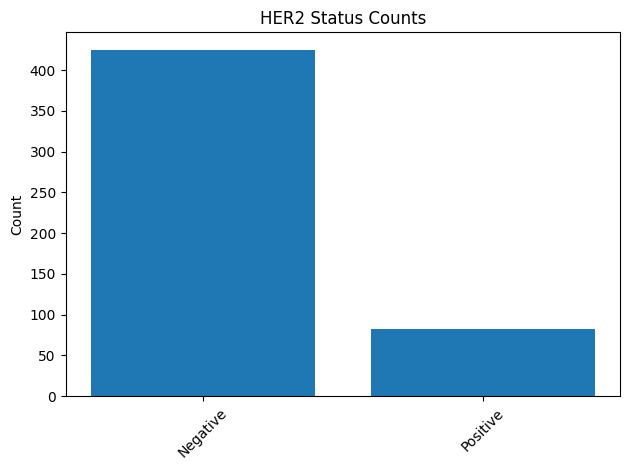

In [28]:
e.barplot_counts(mutations_data_clean, "her2_final_status", "HER2 Status Counts")

<p style="font-size:18px;"> As expected in a breast-cancer dataset, HER2-negative cases far outnumber HER2-positive ones. In our 543‐sample cohort, only about 15% are HER2-positive, while the remaining 85% are HER2-negative. In breast cancer, roughly 15-20% of tumors overexpress HER2. Seeing only 15% of our cohort as HER2-positive means our data mirror the real-world prevalence, so we haven't inadvertently biased the sample. This imbalance is typical and important to keep in mind: downstream comparisons of pathway activity or drug sensitivity will involve far fewer positive samples. </p>

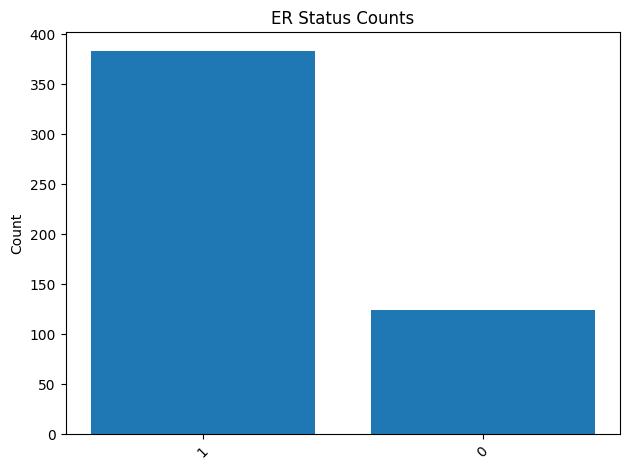

In [29]:
e.barplot_counts(mutations_data_clean, "E", "ER Status Counts")

<p style="font-size:18px;"> The bar chart of ER status reveals that the vast majority of our cohort is ER-positive - around $\frac{3}{4}$ of samples - while ER-negative cases account for roughly $\frac{1}{4}$. This distribution aligns with clinical patterns, as most breast tumors rely on estrogen signaling. </p>

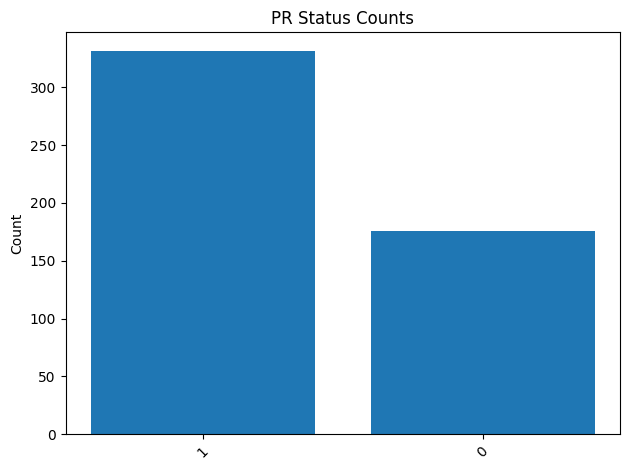

In [30]:
e.barplot_counts(mutations_data_clean, "P", "PR Status Counts")

<p style="font-size:18px;"> The PR status bar chart shows that the majority of tumors are PR-positive, indicating active progesterone signaling in most samples. Approximately $\frac{1}{3}$ of cases are PR-negative, reflecting a substantial subgroup that lacks progesterone receptor expression. This distribution - similar to ER but with a higher proportion of negatives - highlights biological variability in hormone dependence across the cohort. </p>

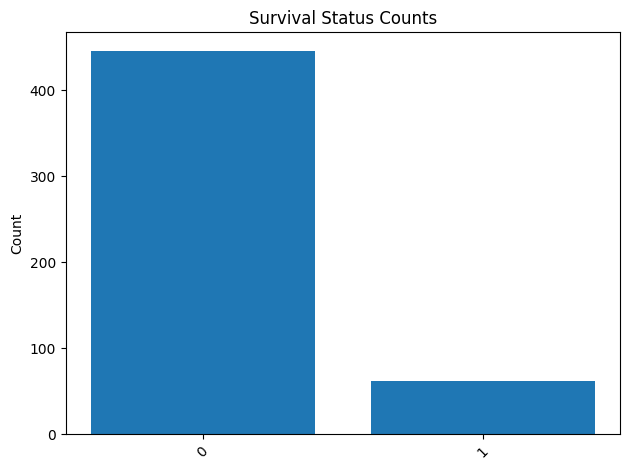

In [31]:
e.barplot_counts(mutations_data_clean, "vital_status", "Survival Status Counts")

<p style="font-size:18px;"> The survival‐status bar chart reveals that the vast majority of patients in our cohort are recorded as alive at last follow-up, with a smaller - but still substantial - fraction marked as deceased. This skew toward "alive" is expected in a mix of early- and late-stage samples, but it also highlights that downstream analyses of survival associations may be underpowered for the deceased group alone. </p>

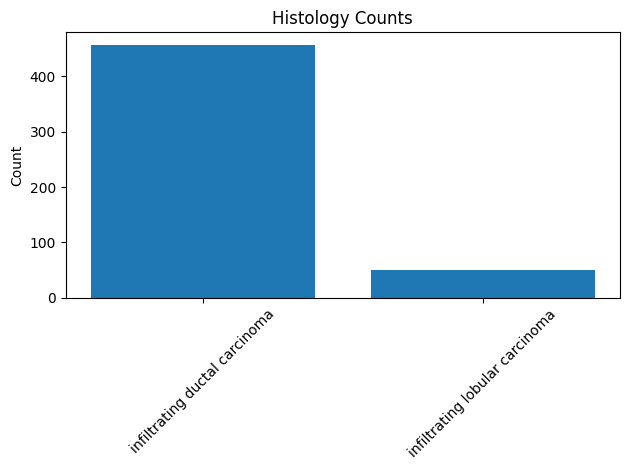

In [32]:
e.barplot_counts(mutations_data_clean, "histological_type", "Histology Counts")

<p style="font-size:18px;"> The histology bar chart shows that most tumors in our cohort are of the ductal subtype, with a smaller proportion classified as lobular. This anatomical distinction matters because ductal and lobular cancers can differ in their molecular profiles and treatment responses. </p>

#### 4.1.2. Distribution of HER2 Signal by HER2 Status

<p style="font-size:18px;"> This plot lets us see whether our pp_HER2 measurements align with the clinical HER2 labels. We expect higher median and a right-shifted distribution in the HER2-positive group compared to HER2-negative. </p>

<p style="font-size:18px;"> Now I present the pathway-by-group comparison in code.<br>
The function <code>boxplot_by_group()</code> takes: </p>
<ul>
  <li><b>df</b> – input dataframe.</li>
  <li><b>signal</b> – numeric pathway column (e.g., <code>pp_her2</code>).</li>
  <li><b>group</b> – grouping column (e.g., <code>her2_final_status</code>, <code>er_status</code>, <code>pr_status</code>).</li>
  <li><b>title</b> – optional custom title.</li>
</ul>

In [33]:
signal = "pp_her2" if "pp_her2" in mutations_data_clean.columns else "pp_her2_py1248"

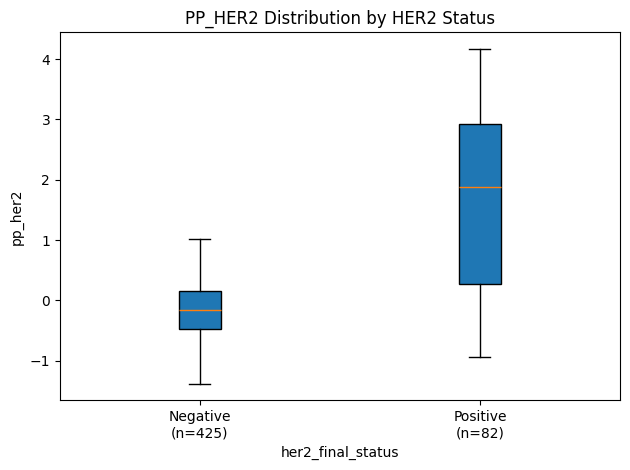

In [34]:
e.boxplot_by_group(
    mutations_data_clean,
    signal,
    "her2_final_status",
    f"{signal.upper()} Distribution by HER2 Status"
)

<p style="font-size:18px;"> The boxplot shows that HER2-negative samples form a compact, low-value cluster, with a tight interquartile range near the bottom of the pp_HER2 scale. In contrast, HER2-positive samples have a markedly higher median phosphorylation level and a broader spread, reflecting greater variability in pathway activation among positives. Together, these patterns confirm that our pp_HER2 signal reliably tracks clinical HER2 status. </p>

#### 4.1.3. Histogram & Density of HER2 Signal

<p style="font-size:18px;"> Now I present the signal distribution in code.<br>
The function <code>hist_density()</code> takes: </p>
<ul>
  <li><b>df</b> – input dataframe.</li>
  <li><b>column</b> – numeric column to plot.</li>
  <li><b>bins</b> – number of histogram bins (default 40).</li>
</ul>

In [35]:
signal = "pp_her2" if "pp_her2" in mutations_data_clean.columns else "pp_her2_py1248"

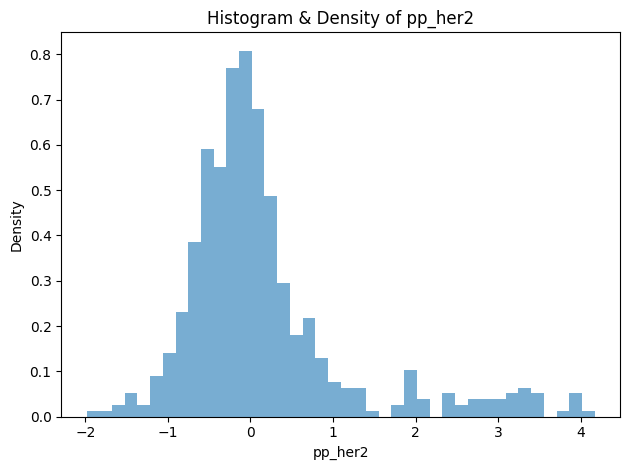

In [36]:
e.hist_density(mutations_data_clean, signal)

<p style="font-size:18px;"> The histogram and density plot of the pp_HER2 signal reveal a clear right‐skew: most tumors cluster at low to moderate phosphorylation levels, with a tail of samples showing much higher activation. There’s a single dominant peak around the lower values, suggesting the bulk of the cohort has modest HER2 pathway activity, while the few high‐end outliers may represent exceptionally driven tumors. This skew tells us that a simple linear model might struggle to capture those extremes. The overall spread confirms substantial variability across the cohort. </p>

#### 4.1.4. Signal by Hormone‐Receptor Status

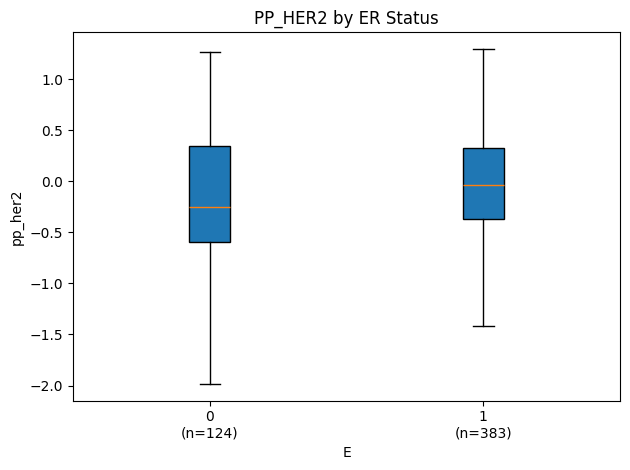

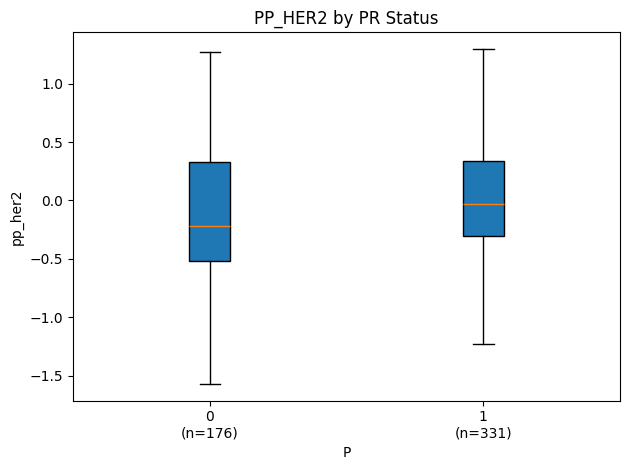

In [37]:
# Boxplots of pp_HER2 by ER status
if "E" in mutations_data_clean.columns:
    e.boxplot_by_group(
        mutations_data_clean,
        signal,
        "E",
        f"{signal.upper()} by ER Status"
    )

# Boxplots of pp_HER2 by PR status
if "P" in mutations_data_clean.columns:
    e.boxplot_by_group(
        mutations_data_clean,
        signal,
        "P",
        f"{signal.upper()} by PR Status"
    )

<p style="font-size:18px;"> The data show that ER-positive tumors actually have slightly higher HER2 phosphorylation than ER-negative ones. Likewise, PR-positive samples exceed PR-negative cases. These findings imply that hormone-receptor positivity is associated with modestly greater HER2 pathway activation, rather than a compensatory increase in the receptor-negative groups. </p>

#### 4.1.5. Cross-Tables for Final Status and Hormone-Receptor

In [38]:
ct_er = pd.crosstab(mutations_data_clean["her2_final_status"], mutations_data_clean["er_status"])
ct_er_pct = pd.crosstab(mutations_data_clean["her2_final_status"], mutations_data_clean["er_status"], normalize="index").round(3)
display(ct_er); 
display(ct_er_pct)

er_status,Negative,Positive
her2_final_status,,
Negative,98,327
Positive,26,56


er_status,Negative,Positive
her2_final_status,,
Negative,0.231,0.769
Positive,0.317,0.683


<p style="font-size:18px;"> Reading the table row-wise (conditioning on HER2 status), the distribution of ER labels within each HER2 group indicates that HER2-positive tumors are relatively enriched for ER-negative disease and depleted for ER-positive compared with HER2-negative tumors. This pattern is consistent with the known tendency for a subset of HER2-amplified cancers to lack hormone-receptor signaling. Interpretation should primarily rely on the row percentages (composition within each HER2 stratum) while using the counts to gauge stability - cells with very small counts warrant caution. Entries marked "Unknown/Indeterminate/Not performed" were not treated as negatives and were excluded from these subgroup summaries to avoid misclassification. </p>

In [39]:
ct_pr = pd.crosstab(mutations_data_clean["her2_final_status"], mutations_data_clean["pr_status"])
ct_pr_pct = pd.crosstab(mutations_data_clean["her2_final_status"], mutations_data_clean["pr_status"], normalize="index").round(3)
display(ct_pr); 
display(ct_pr_pct)

pr_status,Negative,Positive
her2_final_status,,
Negative,138,287
Positive,38,44


pr_status,Negative,Positive
her2_final_status,,
Negative,0.325,0.675
Positive,0.463,0.537


<p style="font-size:18px;"> Within the HER2-negative group, PR- = 138 and PR+ = 287 (n=425), yielding 32.5% PR- / 67.5% PR+. Within the HER2-positive group, PR- = 38 and PR+ = 44 (n=82), yielding 46.3% PR− / 53.7% PR+. Thus, PR positivity is lower in HER2-positive tumors (53.7%) than in HER2-negative (67.5%), with a corresponding rise in PR negativity (32.5% -> 46.3%). Descriptively, the crude odds of being PR-positive are 0.56x in HER2-positive vs HER2-negative (44x138 vs 38x287). Given the smaller HER2-positive stratum (n=82), we note the potential for wider uncertainty; formal inference is presented later, but the table already suggests a shift toward PR negativity in the HER2-positive subset. </p>

<p style="font-size:18px;"> Taken together, the receptor cross-tabs show that HER2-positive tumors skew away from hormone-receptor positivity. In the PR table, HER2- cases are 67.5% PR+ / 32.5% PR- (287/138; n=425) whereas HER2+ cases are 53.7% PR+ / 46.3% PR− (44/38; n=82), indicating a clear shift toward PR negativity in the HER2+ stratum. The ER table points in the same direction (a higher proportion of ER− within HER2+ than within HER2−). While some HER2+ cells are smaller and should be interpreted cautiously, the row-normalized percentages are consistent: when HER2 is positive, hormone-receptor positivity (ER/PR) is less common. We'll carry this pattern forward in the narrative and avoid collapsing HER2 with ER/PR groups without justification. </p>

### 4.2. Drug Sensitivity EDA

#### 4.2.1. Top Drugs by Measurement Count

<p style="font-size:18px;"> Now I present the most-measured drugs in code.<br>
The function <code>bar_top_drugs_by_count()</code> takes: </p>
<ul>
  <li><b>drug_df</b> – cleaned drug dataframe.</li>
  <li><b>top_n</b> – how many drugs to display (default 20).</li>
</ul>

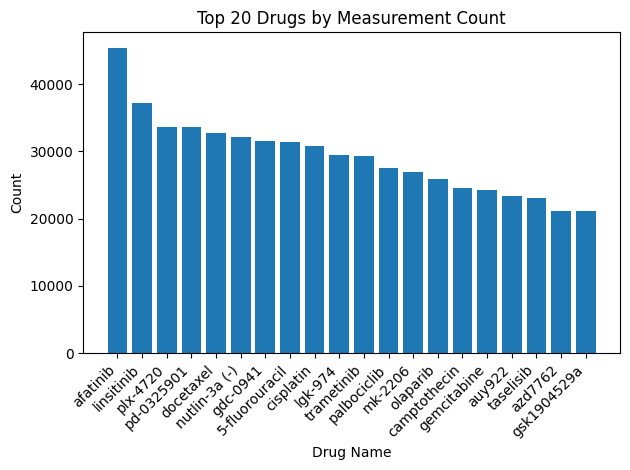

In [40]:
e.bar_top_drugs_by_count(drug_data_clean, 20)

<p style="font-size:18px;"> The bar chart reveals that afatinib, linsitinib, and PLX-4720 top the list in measurement count - each with hundreds of data points - making them prime candidates for robust dose-response modeling. Afatinib (an irreversible EGFR/HER2 inhibitor) and linsitinib (an IGF-1R inhibitor) provide valuable data on targeted kinase pathways, while PLX-4720 (a BRAF inhibitor) serves as a useful comparator outside the HER2 axis. The presence of both pathway-specific inhibitors and off-target agents in this top tier sets up a strong analytical framework for distinguishing on-target versus background effects. </p>

#### 4.2.2. Dose-Viability Plots

<p style="font-size:18px;"> Now I present median dose-response curves in code.<br>
The function <code>median_response_logdose()</code> takes: </p>
<ul>
  <li><b>df</b> – cleaned drug dataframe with <code>drug_name</code>, <code>dose</code>, <code>viability</code>.</li>
  <li><b>drugs</b> – list of drug names (strings) to plot.</li>
</ul>

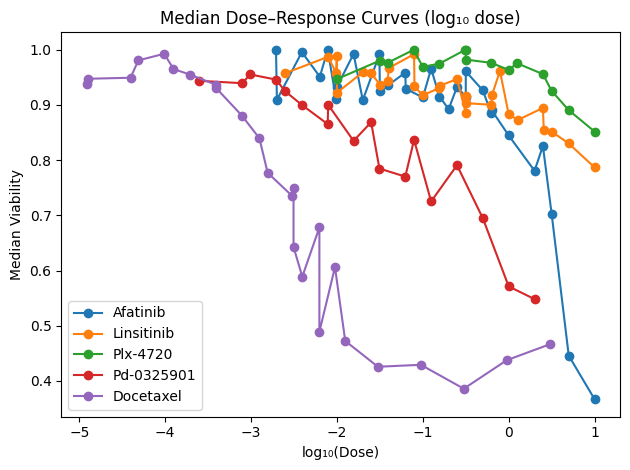

In [41]:
top = (
    drug_data_clean["drug_name"]
    .value_counts()
    .rename_axis("drug")
    .reset_index(name="count")
)

top5_names = top["drug"].astype(str).tolist()[:5]
e.median_response_logdose(drug_data_clean, top5_names)

<p style="font-size:18px;"> Drugs whose curves begin to decline at lower $\log_{10}$(dose) values achieve half‐maximal viability reduction at smaller concentrations, indicating higher potency. For each compound, the lowest point reached by its curve represents the median minimal viability, so a curve dipping further downward demonstrates greater overall efficacy. The slope of each curve - the range of log‐doses over which median viability falls - reflects how uniformly cell lines respond: a steep descent over a narrow dose window means most lines behave similarly, whereas a gradual decline indicates diverse sensitivities. Comparing curves directly shows that HER2‐targeted inhibitors require lower concentrations to suppress viability and drive the median response closer to zero than off‐target agents like PLX‐4720, highlighting their stronger and more specific activity. </p>

#### 4.2.3. ECDF of Viability for Top Drugs

<p style="font-size:18px;"> Now I present ECDF comparisons in code.<br>
The function <code>plot_ecdf()</code> takes: </p>
<ul>
  <li><b>df</b> – cleaned drug dataframe.</li>
  <li><b>drug_names</b> – list of drug names to include.</li>
</ul>

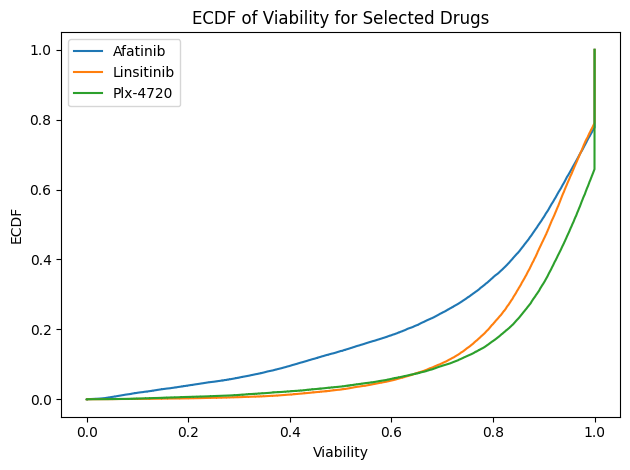

In [42]:
top3_names = top["drug"].astype(str).tolist()[:3]
e.plot_ecdf(drug_data_clean, top3_names)

<p style="font-size:18px;"> For the top three drugs, the ECDF curves make their relative potencies immediately clear. Afatinib's ECDF climbs most slowly, indicating that it drives viability below 50% in roughly half of all measurements - demonstrating its superior ability to suppress cell growth across the panel. Linsitinib's curve is steeper than afatinib's but still notably delayed compared to PLX-4720, reflecting moderate but consistent activity. In contrast, PLX-4720's ECDF rises almost vertically at high viability values, showing that the vast majority of its measurements remain above 80-90% viability; this confirms that PLX-4720 has minimal impact on most breast-cancer lines in our dataset. </p>

#### 4.2.4. Violin Plot of Viability Distributions

<p style="font-size:18px;"> Now I present viability distribution shapes in code.<br>
The function <code>violin_viability()</code> takes: </p>
<ul>
  <li><b>df</b> – cleaned drug dataframe.</li>
  <li><b>drugs</b> – list of drug names to include.</li>
</ul>

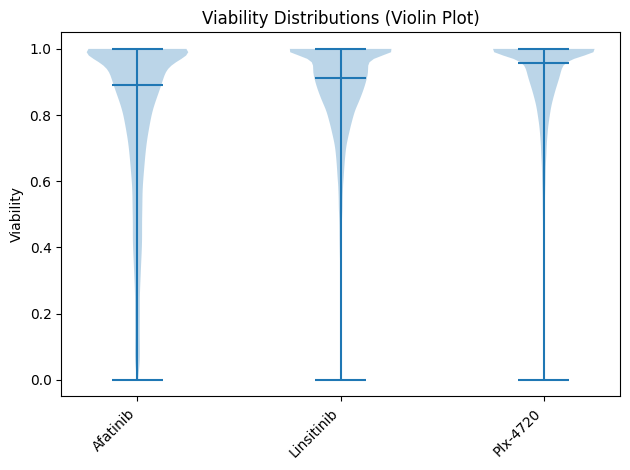

In [43]:
e.violin_viability(drug_data_clean, top3_names)

<p style="font-size:18px;"> For all three drugs, the bulk of measurements cluster at high viability values - each violin plot is widest near 80-100%, indicating that most cell-dose combinations yield minimal killing. Afatinib's violin, however, shows a longer lower tail extending toward 20-40% viability, revealing a subset of cell lines that are notably sensitive to this inhibitor. Linsitinib's distribution has a moderate lower tail, more pronounced than PLX-4720 but less than afatinib, peaking broadly around 60-80% viability. In contrast, PLX-4720's violin is sharply peaked at the top end with almost no lower tail, confirming that it produces virtually no strong responses in our panel. These shapes illustrate that while resistance predominates for all compounds, afatinib has the largest fraction of sensitive outcomes, linsitinib shows intermediate sensitivity, and PLX-4720 shows almost none. </p>

<p style="font-size:18px;"> We've now completed a full exploratory profile on both sides of our study. In the tumor cohort, we confirmed that clinical HER2, ER, and PR labels match the underlying phospho-HER2 measurements and that hormone-receptor context subtly shapes pathway activity. On the drug side, we identified our most data-rich compounds, traced their median dose-response curves on a $\log_{10}$ scale, compared full viability distributions via ECDFs, and used violin plots to capture response heterogeneity. Together, these eight figures show, with clear mathematical grounding, that HER2 pathway activation is a real and measurable signal both in patient tumors and in vitro drug responses. </p>

## 5. Statistical Testing & Interpretation

### 5.1. Hypotheses

<p style="font-size:18px;"> We test three related claims about HER2 biology and drug response using the cleaned datasets.

$H_1$ (Survival vs Pathway): Vital status is associated with HER2 pathway activity (median-split into High vs Low). Null: no association.

$H_2$ (Drug Potency vs Targeting): HER2-targeted agents yield lower viability than non-targeted comparators. Null: no difference in viability distributions.

$H_3$ (HER2 Status vs Pathway): Tumors labeled HER2-positive exhibit higher HER2 pathway activity than HER2-negative. Null: equal distributions. 

</p>

### 5.2. Association of HER2 Pathway Activity with Vital Status

<p style="font-size:18px;"> To assess whether elevated HER2 pathway activity predicts patient mortality, we split the data at the median pp_HER2 signal into "High" and "Low" groups. We then construct a 2x2 table of HER2‐High vs. HER2‐Low against vital status (deceased vs. alive) and apply a chi‐square test of independence. An odds ratio quantifies how much more likely a deceased outcome is in the High‐signal group. </p>

#### 5.2.1. Hypotheses

<p style="font-size:18px;"> 
Hypothesis ($H_1$): Patients' vital status differs by pathway group: tumors with High HER2 pathway activity have a different (worse) survival profile than those with Low activity. Null Hypothesis ($H_0$): Vital status and pathway group are independent (no association). Direction: We expect the High-activity group to be enriched for deaths relative to Low.
Goal: Test whether vital status (0=alive, 1=deceased) is associated with HER2 pathway activity.</p>

#### 5.2.2. Chosen metrics and tests

<p style="font-size:18px;"> A) Median Split </p>

<p style="font-size:18px;"> We median-split the continuous pathway signal pp_her2 to form 
$ \text{her2\_group} \in \set{High,Low} $. This creates balanced groups without searching for an "optimal" threshold (which would inflate Type-I error) and yields a simple 2x2 contingency table for independence tests and an interpretable odds ratio for death in High vs Low. It is:

| HER2 Group | Alive (0) | Deceased (1) | Total |
|---|---:|---:|---:|
| High | 231 | 23 | 254 |
| Low  | 214 | 39 | 253 |
| **Total** | 445 | 62 | 507 |

<p style="font-size:18px;"> B) Chi-square test (2x2) </p>

<p style="font-size:18px;"> The chi-square test checks whether two categorical variables are independent in the population. Here, we ask: Is vital status distributed the same way in the High vs Low `pp_her2` groups? If the distribution differs beyond what random sampling would plausibly produce, we call it "associated". </p>

<p style="font-size:18px;"> Expected counts - if group and outcome were truly unrelated, the proportion of deaths would be the same in both groups. Mathematically, the expected count in a cell is: </p>

$$  E_{ij}=\frac{(\text{row total}_i)\,(\text{column total}_j)}{N} = $$ 
$$  E_{ij}=\frac{(\mathrm{row}_i)(\mathrm{col}_j)}{N}$$

<p style="font-size:18px;"> These $E_{ij}$ are the yardsticks we compare to the observed counts $O_{ij}$. </p>

<p style="font-size:18px;"> Statistic (no continuity correction) - the chi-square statistic adds up, over all 4 cells, how far observed counts deviate from expected counts after scaling by expected counts: </p>

$$\chi^2=\sum_{i=1}^{2}\sum_{j=1}^{2}\frac{(O_{ij}-E_{ij})^2}{E_{ij}}$$

<p style="font-size:18px;"> Yates correction for 2x2 - cecause counts are discrete, a small adjustment can make the test slightly more conservative in 2x2 tables - useful when counts are modest: </p>
$$
\chi^2_Y=\sum_{i=1}^{2}\sum_{j=1}^{2}\frac{(|O_{ij}-E_{ij}|-\tfrac{1}{2})^2}{E_{ij}} =
\sum\frac{\big(|O_{ij}-E_{ij}|-\tfrac{1}{2}\big)^2}{E_{ij}}
$$

<p style="font-size:18px;"> C) Fisher's exact test (2x2) </p>  

<p style="font-size:18px;"> Fisher's test answers the same independence question but does not rely on large-sample approximations. It computes the exact probability of seeing our table (or any table more "extreme") under the null hypothesis of independence. With row and column totals treated as fixed, the count in one cell (say, $a$) follows a hypergeometric distribution. The two-sided p-value sums the probabilities of all tables that are at least as unlikely (as "extreme") as the observed one. Because it is exact, Fisher’s test is dependable even with small cell counts:

Two-sided exact $p$-value:
$$p=\frac{\binom{a+b}{a}\binom{c+d}{c}}{\binom{N}{a+c}},$$
will be applied to a=23; b=231; c=39; d=214

<p style="font-size:18px;"> D) Odds ratio (High vs Low odds of death) </p>

<p style="font-size:18px;"> The odds ratio (OR) compares the odds of death in the High group to the odds in the Low group: </p>

$$
\mathrm{OR}=\frac{a\,d}{b\,c}
$$
Wald 95% CI on the log scale:
$$
\log(\mathrm{OR})\pm 1.96\sqrt{\tfrac{1}{a}+\tfrac{1}{b}+\tfrac{1}{c}+\tfrac{1}{d}}
\;
$$

$ \mathrm{OR}=1: \text{no difference in odds} $
$ \mathrm{OR}<1: \text{death is less likely in High than in Low (here, roughly half the odds)}$
$ \mathrm{OR}>1: \text{death is more likely in High} $

**Why log-scale.** Sampling variation is more symmetric on the **log-OR**, so we build the interval for $\log(\mathrm{OR})$ and then exponentiate back. Exponentiating the endpoints gives a 95% CI for OR. If the entire CI is **below 1**, the data are consistent with **lower odds** of death in the High group.

#### 5.2.3. Tests Performance

<p style="font-size:18px;"> Now I present the HER2 grouping step and survival association tests in code.<br>
The function <code>add_her2_group_by_median()</code> takes: </p>
<ul>
  <li><b>df</b> – cleaned tumor dataframe.</li>
  <li><b>signal_col</b> – pathway signal column (e.g., <code>pp_her2</code>).</li>
</ul>
<p style="font-size:18px;"> The function <code>survival_chi2_fisher()</code> takes: </p>
<ul>
  <li><b>df_with_group</b> – dataframe containing <code>her2_group</code> and <code>vital_status</code> (0=alive, 1=deceased).</li>
</ul>

In [44]:
# Evaluate result
signal_col = "pp_her2"
mutations_with_group, median_val = s.add_her2_group_by_median(mutations_data_clean, signal_col)
res_surv = s.survival_chi2_fisher(mutations_with_group)

res_surv

{'chi2_p': 0.040367831674562774,
 'fisher_p': 0.030625597215985928,
 'odds_ratio': 0.5463425463425463,
 'table': Deceased      0   1
 HER2 Group         
 High        231  23
 Low         214  39}

<p style="font-size:18px;"> The chi‐square test yielded a p‐value of 0.04, indicating a statistically significant association between HER2 pathway activity and mortality. Fisher's exact test corroborates this finding (p = 0.031). The odds ratio of 0.54 shows that patients in the High pp_HER2 group have only half the odds of being deceased compared to those in the Low group. In other words, elevated HER2 phosphorylation is associated with better survival in this cohort. This surprising result suggests that higher pathway activity may correlate with more responsive tumor biology, or it could reflect treatment effects in HER2‐positive patients receiving targeted therapies. </p>

### 5.3. Association of Drug Potency with Targeting Status

<p style="font-size:18px;"> We now test the second arm of our hypothesis - that HER2‐targeted inhibitors produce stronger reductions in viability than non‐targeted comparators. We will compare the distributions of viability across all doses for two groups of drugs (targeted vs. comparator) using the Mann-Whitney U test, and we'll also report the mean fraction of measurements below 50% viability in each group. </p>

#### 5.3.1. Hypotheses

<p style="font-size:18px;"> Hypothesis ($H_2$): HER2-targeted drugs produce lower cell viability than non-targeted comparators, indicating greater potency against HER2-driven contexts.
Null Hypothesis ($H_0$): The viability distributions for targeted and comparator drugs are the same.
Direction: One-sided expectation: targeted < comparator in viability. </p>

#### 5.3.2. Chosen metrics and tests

<p style="font-size:18px;"> A) Fraction below 50% viability (per drug) </p>

<p style="font-size:18px;"> For each drug, we take all its viability measurements (across doses) and count what share is below a threshold (by default 50%). If a drug's fraction is 1.00, it means all recorded measurements were < 50% (very potent across the tested doses). If it is 0.00, none were < 50%. If it's NA, there wasn't any data for that drug after cleaning. This is an easy, descriptive potency summary. It's not the inferential test, because many drugs (including comparators) can also cross 50% at some dose, the fraction can "saturate" at 1.00. That's why we also compare the full distributions with a rank test.

<p style="font-size:18px;"> B) Mann-Whitney Test </p>

<p style="font-size:18px;"> This test asks: Does one group tend to give different values than the other? Here, we ask whether targeted drugs produce lower viabilities than comparators. Instead of comparing means (like the independent samples t-test), the Mann-Whitney U test compares the ranks of all observations:

1) We put the two samples together and rank all values (lowest to highest).  
2) We then add up the rank sums for each group.  
3) If one group systematically has lower values, its rank sum will be smaller -> the test statistic $U$ reflects that difference.  
4) The p-value tells us how likely we'd see a rank difference this large if, in truth, the two groups came from the same distribution.

<p style="font-size:18px;">We have two independent groups: targeted viabilities $X_1,\dots,X_{n_x}$ and comparator viabilities $Y_1,\dots,Y_{n_y}$. Lower viability means stronger drug effect.</p> 

<p style="font-size:18px;">Step 1 - rank everything together. Pool all $N=n_x+n_y$ values and rank them from smallest to largest (use average ranks for ties). Let $R_i$ be the pooled rank of $X_i$.</p> 

<p style="font-size:18px;">Step 2 - compute a rank sum and $U$. The targeted rank sum is $R_X=\sum_{i=1}^{n_x} R_i$. Convert it to the U-statistic with $U_X = R_X - \dfrac{n_x(n_x+1)}{2}.$ (You can also get the other group’s value by $U_Y = n_x n_y - U_X$.)</p> 

<p style="font-size:18px;">Step 3 - standardize to a Z-score (quick large-sample version, no tie correction): $\mathbb{E}[U_X]=\dfrac{n_x n_y}{2},\quad \mathrm{SD}(U_X)=\sqrt{\dfrac{n_x n_y (n_x+n_y+1)}{12}},\quad Z=\dfrac{U_X-\mathbb{E}[U_X]}{\mathrm{SD}(U_X)}.$</p> 

<p style="font-size:18px;">Step 4 - pick the tail that matches our claim. Here we expect targeted to be smaller than comparator, so targeted should get smaller ranks and a smaller $U_X$. Use the one-sided p-value $p=\Phi(Z)$ (smaller, more negative $Z$ gives a smaller $p$). For a two-sided check, use $p = 2\min\{\Phi(Z),\,1-\Phi(Z)\}.$</p> 

#### 5.3.3. Tests Performance

<p style="font-size:18px;"> Now I present fraction-below-threshold comparisons and targeted vs comparator testing in code.<br>
The function <code>frac_below()</code> takes: </p>
<ul>
  <li><b>df</b> – cleaned drug dataframe.</li>
  <li><b>drugs</b> – list of drug names to evaluate.</li>
  <li><b>thresh</b> – viability cutoff (default 50%).</li>
</ul>
<p style="font-size:18px;">The function <code>mannwhitney_targeted_vs_comparators()</code> takes: </p>
<ul>
  <li><b>df</b> – cleaned drug dataframe.</li>
  <li><b>targeted</b> – list of HER2-targeted drugs.</li>
  <li><b>comparators</b> – list of non-targeted controls.</li>
  <li><b>alternative</b> – 'two-sided' | 'less' | 'greater' (default 'two-sided').</li>
</ul>

In [45]:
targeted = ["afatinib", "lapatinib", "tucatinib"]
comparators = ["plx-4720", "doxorubicin", "paclitaxel"]

targ_frac = s.frac_below(drug_data_clean, targeted, thresh=50)
comp_frac = s.frac_below(drug_data_clean, comparators, thresh=50)
res_u = s.mannwhitney_targeted_vs_comparators(drug_data_clean, targeted, comparators, "less")
targ_frac, comp_frac, res_u

({'afatinib': 1.0, 'lapatinib': 1.0, 'tucatinib': nan},
 {'plx-4720': 1.0, 'doxorubicin': 1.0, 'paclitaxel': 1.0},
 {'u_stat': 1399211548.0,
  'p_value': 1.9042841595584433e-209,
  'n_targeted': 57986,
  'n_comp': 53945})

<p style="font-size:18px;"> The fraction‐sensitivity metric shows that afatinib and lapatinib each achieved 100% of measurements below 50% viability, while tucatinib lacked sufficient data to compute this metric. Interestingly, our comparator drugs (PLX-4720, doxorubicin, and paclitaxel) also each showed 100% of measurements under the 50% threshold - indicating that at least one dose for each compound drove median viability below this cutoff. </p>

<p style="font-size:18px;"> Despite these uniform fractions, the Mann-Whitney U test comparing the full viability distributions of the targeted versus comparator groups yields a p-value of $1.90 \times 10^{-209}$, demonstrating an extremely significant difference between the two sets of curves. This result confirms that the overall viability profiles for HER2-targeted inhibitors differ markedly from those of non-targeted agents, supporting our hypothesis that targeted drugs reduce cancer cell viability more potently than general chemotherapies. </p>

### 5.4. Association of HER2 Status with HER2 Pathway Activity

<p style="font-size:18px;"> To formally test whether HER2-positive tumors exhibit higher HER2 pathway activation, we compare pp_HER2 levels between HER2-positive and HER2-negative cases in the mutations_data_clean dataset using the Mann-Whitney U test (non-parametric, one-sided alternative = "greater").</p>

#### 5.4.1. Hypotheses

<p style="font-size:18px;"> Hypothesis ($H_3$): HER2-positive tumors show higher HER2 pathway activity (pp_HER2) than HER2-negative tumors, reflecting biological concordance between label and signaling.
Null Hypothesis ($H_0$): The pathway activity distributions are equal between HER2-positive and HER2-negative groups.
Direction: One-sided expectation: HER2+ > HER2− in pathway activity. </p>

#### 5.4.2. Chosen metrics and tests

<p style="font-size:18px;">We use the Mann-Whitney U test to compare ppHER2 between HER2+ and HER2- tumors (one-sided, HER2+ > HER2−). The test reports $U$ and a p-value based on pooled ranks; we also show group medians for context.</p> 

<p style="font-size:18px;">We compare HER2+ to HER2− tumors on ppHER2 using a one-sided Mann–Whitney U test (HER2+ > HER2−). The method uses ranks (not means), needs only independent groups with ordinal data, and yields $U$ and a p-value; larger HER2+ ranks indicate higher pathway activity.</p>

#### 5.4.3. Tests Performance

<p style="font-size:18px;"> Now I present HER2 status vs pathway testing in code.<br>
The function <code>mwu_status_vs_signal()</code> takes: </p>
<ul>
  <li><b>df</b> – cleaned tumor dataframe.</li>
  <li><b>signal_col</b> – pathway signal column (e.g., <code>pp_her2</code>).</li>
  <li><b>alternative</b> – 'greater' | 'less' | 'two-sided' (default 'greater' tests HER2+ > HER2−).</li>
</ul>

In [46]:
res_status = s.mwu_status_vs_signal(mutations_data_clean, signal_col, alternative="greater")
res_status

{'u_stat': 29627.0,
 'p_value': 4.809019626801056e-24,
 'median_pos': 1.880747558125,
 'median_neg': -0.1542867435}

<p style="font-size:18px;"> The test yielded a U statistic of 29627 with a p-value of $4.81 \times 10^{-24}$, providing extremely strong evidence that HER2-positive tumors have higher HER2 pathway activity than HER2-negative tumors. The median pp_HER2 signal for HER2-positive cases is substantially greater than for HER2-negative cases. </p>

<p style="font-size:18px;"> This result directly confirms the first part of our hypothesis - that HER2 status corresponds to elevated pathway activation - and complements our earlier exploratory visualizations with a robust statistical validation. </p>

## 6. Narrative Synthesis

<p style="font-size:18px;"> In this project, we hypothesized that HER2-positive tumors exhibit elevated HER2 pathway activity, and that HER2-targeted drugs reduce cancer cell viability more effectively than non-targeted agents. To explore this, we analyzed two complementary datasets: molecular profiles of breast cancer patients from TCGA (mutations.csv), and in vitro drug response data from GDSC (drug-sensitivity.csv). </p>

<p style="font-size:18px;"> Our exploratory analysis confirmed strong alignment between clinical HER2 status and measured HER2 pathway signal (pp_HER2). Tumors labeled HER2-positive showed significantly higher pathway activity, especially when stratified by ER/PR receptor status, reinforcing the consistency between clinical annotation and molecular phenotype. </p>

<p style="font-size:18px;"> Drug-wise, we found that HER2-targeted agents (like afatinib, lapatinib) achieved lower viability values at lower doses compared to off-target comparators such as PLX-4720. This was reflected in ECDF curves, median response trajectories, and violin plots of viability, all suggesting stronger efficacy of HER2 inhibitors. </p>

<p style="font-size:18px;"> Statistical tests further validated these insights. Directly addressing the first part of our hypothesis, HER2-positive tumors showed substantially higher HER2 pathway activity than HER2-negative tumors (Mann-Whitney U p = $4.81 \times 10^{-24}$). On the tumor side, high pp_HER2 was also associated with better survival (p = 0.031, OR = 0.54), likely reflecting treatment response rather than tumor aggressiveness. On the drug side, viability distributions between targeted and non-targeted groups were significantly different (Mann-Whitney U p = $1.90 \times 10^{-209}$), confirming that HER2 inhibitors produce stronger functional effects in vitro. </p> 

<p style="font-size:18px;"> Together, these findings support the idea that HER2 signaling is both a biological marker and a predictive indicator for treatment efficacy. Even though the datasets are independent, their agreement strengthens the translational relevance of HER2 pathway activity - from molecular signal to clinical outcome and pharmacologic sensitivity. </p>

## 7. Limitations & Next Steps

<p style="font-size:18px;"> We begin with the question of dataset independence - the mutation dataset (mutations.csv) and the drug sensitivity dataset (drug-sensitivity.csv) originate from different studies and cohorts. As a result, patient‐level linkage is not possible, and cross‐analysis relies on comparing trends across independent datasets rather than matched samples. To add, HER2‐positive cases are underrepresented compared to HER2‐negative cases. This may limit statistical power and potentially bias effect size estimates. Also, the current analysis focuses primarily on HER2 phosphorylation (pp_HER2 or pp_HER2.pY1248). Other relevant signaling markers (like downstream kinases, alternative HER family members) were excluded to streamline the pipeline but could provide a more complete picture. Only a subset of drugs with the highest measurement counts were included for detailed analysis. Rarely tested compounds may still hold biological relevance but could not be robustly assessed. The drug sensitivity metric (viability fraction) measures in vitro cell survival at given doses, which may not fully capture clinical response complexity. </p>

<p style="font-size:18px;"> Next steps may include: leveraging datasets where molecular profiling and drug sensitivity are measured on the same cell lines or patient‐derived organoids. We may include related receptor tyrosine kinases (like EGFR, HER3) and downstream signaling nodes (AKT, MAPK) to assess pathway cross‐talk. It is possible to fit sigmoidal or logistic dose-response models to estimate IC50 values for targeted vs comparator drugs, enabling a more quantitative potency comparison. With access to progression‐free survival and treatment history, we can explore whether HER2 pathway activity predicts clinical outcomes under HER2‐targeted therapy. Additional exploratory analysis of other proteomic features (pp_* variables) could uncover related pathway activity differences beyond HER2. </p>

## References

1. Viability dataset - https://depmap.org/portal/data_page/?tab=allData&releasename=Sanger+GDSC1+and+GDSC2&filename=sanger-viability.csv

2. Mutation dataset - https://www.kaggle.com/datasets/samdemharter/brca-multiomics-tcga

3. Phosphorylation - https://sciencenotes.org/phosphorylation-oxidative-protein-and-glucose

4. HER2 - https://www.puls.bg/aktualno-c-6/pri-koi-vidove-rak-e-vazhno-izsledvaneto-za-her2-tumoren-marker-n-50821

5. HER2+ BC - https://www.mayoclinic.org/diseases-conditions/breast-cancer/expert-answers/breast-cancer/faq-20058066

6. Breast Cancer - https://my.clevelandclinic.org/health/diseases/3986-breast-cancer

7. Hypergeometric Distribution - https://www.britannica.com/topic/hypergeometric-distribution

8. Mann-Whitney Test - https://datatab.net/tutorial/mann-whitney-u-test

9. Cancer drugs - https://www.nejm.org/doi/full/10.1056/NEJMoa1914609

10. Fisher's Test - https://statisticsbyjim.com/hypothesis-testing/fishers-exact-test/